In [2]:
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
from sklearn.model_selection import StratifiedKFold
from random import uniform,choice
from os import remove
import re
from sklearn.metrics import f1_score,precision_score,recall_score

code to read MR dataset 

In [3]:
# def load_data(filename):
#     with open(filename,'r') as fin:
#         return json.load(fin)

In [4]:
# dataset_dict = load_data("dataset/final_dataset.json")

In [5]:
# def extract_data(dataset_dict):
#     review = [dataset_dict[key]["review"] for key in dataset_dict.keys()]
#     polarity = [dataset_dict[key]["polarity"] for key in dataset_dict.keys()]
#     return review, polarity 

In [6]:
# review, polarity = extract_data(dataset_dict)

In [7]:
# review = review[:100]
# polarity = polarity[:100]

Code to read smm4h dataset

In [8]:
def load_data_from_file(filename):
    data = pd.read_csv(filename, sep="\t", header=None)
    data.columns = ["tweet_id", "username", "database_id", "class","tweet"]
    return data

In [9]:
train_data = load_data_from_file('dataset/smm4h/personal_intake_tweets.txt')

In [10]:
dev_data = load_data_from_file('dataset/smm4h/personal_intake_tweets_dev.txt')

In [11]:
train_sentences = train_data['tweet'].tolist()+dev_data['tweet'].tolist()
train_labels = train_data['class'].tolist()+dev_data['class'].tolist()

In [12]:
len(train_sentences),len(train_labels)

(9107, 9107)

In [13]:
train_labels.count(1),train_labels.count(2),train_labels.count(3)

(1743, 2837, 4527)

In [14]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #for PYTHON 2.7
    #tokens = [w.translate(None, string.punctuation) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [15]:
print("cleaning train data")
trainX = [clean_sentence(s) for s in train_sentences]
trainY = np.array([l-1 for l in train_labels])

cleaning train data


In [16]:
length = [len(s) for s in trainX]

5908

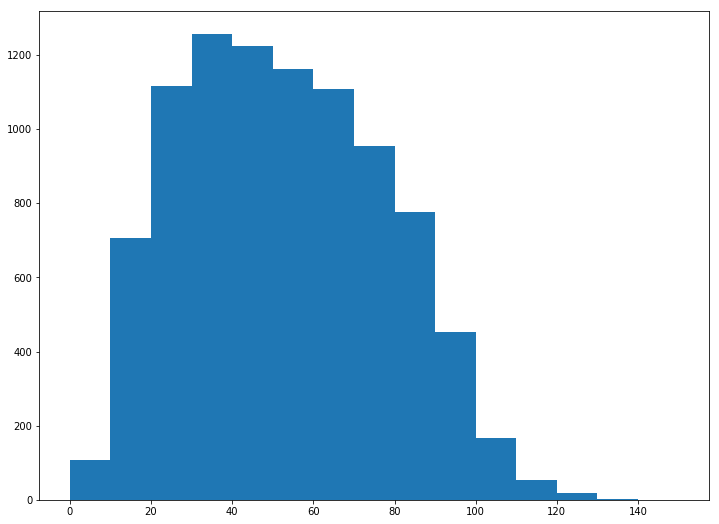

In [17]:
plt.hist(length,bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150])
max(length)

In [18]:
max_len = 150

In [19]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [21]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    print('Loading GloVe word vectors.')
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [22]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [23]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('word_embeddings/fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','word_embeddings/fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [24]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [25]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [26]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [27]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [28]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [29]:
def define_model(length,vocab_size,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag_c1,em_trainable_flag_c2,em_trainable_flag_c3):
    # channel 1
    inputs1 = Input(shape=(length,))
    if em_c1 == 'free':
        embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
    else:
        embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag_c1)(inputs1)
    
    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(embedding1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    if em_c2 == 'free':
        embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
    else:
        embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag_c2)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(embedding2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    if em_c3 == 'free':
        embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
    else:
        embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag_c3)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(embedding3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(3, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # summarize
#     print(model.summary())
    return model

In [30]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)

Max document length: 150
Vocabulary size: 10940


In [31]:
# glove_model = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
# fast_text_model = load_fast_text_model(train_sentences)
# godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [32]:
# embedding_matrix_glove = get_GloVe_embedding_matrix(glove_model)
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)
# embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)
# embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

In [33]:
seed = 7
np.random.seed(seed)

In [34]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [45]:
def get_parameters():
    #range values
    para_n_dense = [100,200,300,400]
    para_n_filters = [100,200,300,400]
    para_filter_size = [1,2,3,4,5,6]
#     para_em = ['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free']
    para_em = ['embedding_matrix_word2vec']
    para_free_em_dim = [100,300,400]
    para_em_trainable_flag = [True,False]
    para_batch_size = [8,16,32,64]
#     para_epoc = [10,30,60,100]
    para_epoc = [1]
#     para_batch_size = [64]
    #selecting_random_value
    parameters = {"n_dense": choice(para_n_dense),
            "dropout": uniform(0.4, 0.9),
            "learning_rate": uniform(0.0001, 0.01),
            "n_filters": choice(para_n_filters),
            "filter_size_c1": choice(para_filter_size),
            "filter_size_c2": choice(para_filter_size),
            "filter_size_c3": choice(para_filter_size),
            "em_c1": choice(para_em),
            "em_c2": choice(para_em),
            "em_c3": choice(para_em),
            "free_em_dim": choice(para_free_em_dim),
            "em_trainable_flag_c1": choice(para_em_trainable_flag),
            "em_trainable_flag_c2": choice(para_em_trainable_flag),
            "em_trainable_flag_c3": choice(para_em_trainable_flag),
            "batch": choice(para_batch_size),
            "epoch": choice(para_epoc)
        }
    return parameters

In [55]:
key = 1
record = {}

In [56]:
number_of_models = 1

In [ ]:
for _ in range(number_of_models):
    itr = 1
    f1_record = []
    p_record = []
    r_record = []
    itr_record = {}
    parameters = get_parameters()
#     parameters = {
#             "n_dense": 400,
#             "dropout": 0.5777195655120914,
#             "learning_rate": 0.0071353667446707675,
#             "n_filters": 100,
#             "filter_size_c1": 6,
#             "filter_size_c2": 4,
#             "filter_size_c3": 4,
#             "em_c1": "embedding_matrix_word2vec",
#             "em_c2": "embedding_matrix_word2vec",
#             "em_c3": "embedding_matrix_word2vec",
#             "free_em_dim": 400,
#             "em_trainable_flag_c1": False,
#             "em_trainable_flag_c2": True,
#             "em_trainable_flag_c3": False,
#             "batch": 16,
#             "epoch": 1
#         }
    print("model number {0}".format(key))
    print(parameters)
    for train,test in kfold.split(trainX,trainY):
        print("k fold validation itr == {0}".format(itr))
        X = trainX[train]
        Y = to_categorical(trainY[train],num_classes=3)
        X_ = trainX[test]
        Y_ = list(trainY[test])
        model = define_model(length = max_len,
                             vocab_size=vocab_size,
                             n_dense = parameters["n_dense"],
                             dropout = parameters["dropout"],
                             learning_rate = parameters["learning_rate"],
                             n_filters = parameters["n_filters"],
                             filter_size_c1 = parameters["filter_size_c1"],
                             filter_size_c2 = parameters["filter_size_c2"],
                             filter_size_c3 = parameters["filter_size_c3"],
                             em_c1 = parameters["em_c1"],
                             em_c2 = parameters["em_c1"],
                             em_c3 = parameters["em_c1"],
                             free_em_dim = parameters["free_em_dim"],
                             em_trainable_flag_c1 = parameters["em_trainable_flag_c1"],
                             em_trainable_flag_c2 = parameters["em_trainable_flag_c2"],
                             em_trainable_flag_c3 = parameters["em_trainable_flag_c3"])
        history = model.fit([X,X,X],Y,epochs=parameters["epoch"],batch_size=parameters["batch"])
        pred = model.predict([X_,X_,X_])
        pred_labels = [x.argmax() for x in pred]
        for foo in zip(Y_[:50],pred_labels[:50]):
            print(foo)
        f1 = f1_score(Y_,pred_labels,labels=[0,1],average='micro')
        p = precision_score(Y_,pred_labels,labels=[0,1],average='micro')
        r = recall_score(Y_,pred_labels,labels=[0,1],average='micro')
        print(f1,p,r)
        f1_record.append(f1)
        p_record.append(p)
        r_record.append(r)
        itr_record[itr] = {}
        itr_record[itr]["f1"] = f1
        itr_record[itr]["p"] = p
        itr_record[itr]["r"] = r
        model.save('models/'+str(key)+'_'+str(itr)+'.h5')
        itr+=1
    record[key] = {}
    record[key]["parameter"] = parameters
    record[key]["mean_f1"] = np.mean(f1_record)
    record[key]["itr_record"] = itr_record

    with open("models/record.json",'w')as fout:
        json.dump(record,fout,indent=4)
    key+=1

model number 1
{'n_dense': 300, 'dropout': 0.6185354212195162, 'learning_rate': 0.004108416629722289, 'n_filters': 400, 'filter_size_c1': 4, 'filter_size_c2': 4, 'filter_size_c3': 2, 'em_c1': 'embedding_matrix_word2vec', 'em_c2': 'embedding_matrix_word2vec', 'em_c3': 'embedding_matrix_word2vec', 'free_em_dim': 300, 'em_trainable_flag_c1': False, 'em_trainable_flag_c2': False, 'em_trainable_flag_c3': True, 'batch': 16, 'epoch': 1}
k fold validation itr == 1
Epoch 1/1
7284/7284 [==============================] - 320s 44ms/step - loss: 0.5143 - acc: 0.7525
(1, 1)
(1, 0)
(2, 2)
(2, 2)
(0, 0)
(2, 2)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1, 1)
(2, 2)
(2, 2)
(0, 0)
(2, 2)
(1, 2)
(0, 0)
(2, 2)
(2, 2)
(1, 2)
(0, 0)
(1, 0)
(2, 2)
(2, 2)
(0, 0)
(2, 2)
(1, 0)
(2, 2)
(1, 0)
(1, 2)
(2, 2)
(1, 1)
(0, 2)
(2, 2)
(2, 2)
(1, 1)
(0, 0)
(2, 2)
(2, 0)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(1, 2)
(2, 2)
(0, 2)
(1, 1)
(2, 2)
(2, 2)
0.5419602818705958 0.656832298136646 0.4612868047982552
k fold validation itr == 2
Epoch 1